# Cross Validation

Based on Anne Barry, Dan Rupp and Jack Bennetto's lectures

## Success Criteria

Today I will be successful if I can... 

 * Describe the three kinds of model error
 * Identify what types of models have high bias and high variance
 * Name two different Error Metrics and calculate MSE
 * Explain k-fold cross validation
 * Explain the training, validation, testing data sets

## Agenda

In this lesson we will talk about

* A simple example
* Bias and Variance
* Train-test split
* K-fold cross validation

## Big Questions:

What common pitfalls do we fall into when training models?

How do we make sure our models will predict on unseen data?

<img src="img/800px-CRISP-DM_Process_Diagram.png" alt="Drawing" style="width: 400px;"/>

[CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) is the Cross-industry standard process for data mining.  The diagram above illustrates the lifecycle of a data science project.  Today we will focus on evaluation.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold

plt.style.use('ggplot')

## Discovering Bias and Variance

In [4]:
pd.read_csv('data/cars.csv').head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [16]:
# cars[cars.horsepower.isnull()]

# model = KNeighborsRegressor(3)
# model.fit(X,y)
# model.predict(x_tick)
# x_tick.reshape(-1,1)
np.sqrt(len(cars))

19.79898987322333

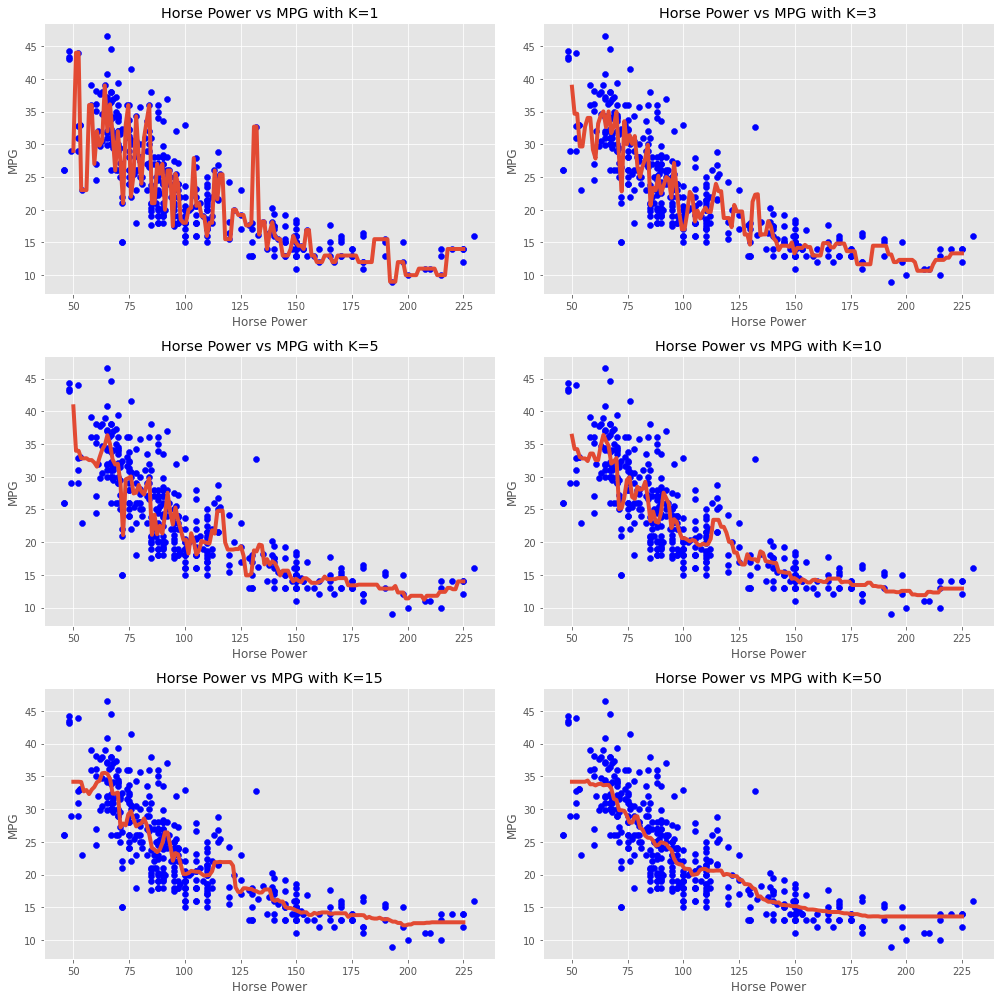

In [5]:
cars = pd.read_csv('data/cars.csv', na_values=['?'])
cars = cars[cars.horsepower.notnull()]

X = cars.horsepower.values
y = cars.mpg.values

fig, axs = plt.subplots(3,2,figsize=(14, 14))
x_tick = np.linspace(50,225,150)
k_num = [1,3,5,10,15,50]

for k, ax in zip(k_num,axs.flatten()):
    model = KNeighborsRegressor(k)
    model.fit(X.reshape(-1,1),y.reshape(-1,1))
    ax.scatter(X,y,c='blue')
    ax.plot(x_tick, model.predict(x_tick.reshape(-1,1)), linewidth=4)
    ax.set_xlabel('Horse Power')
    ax.set_ylabel('MPG')
    ax.set_title('Horse Power vs MPG with K={}'.format(k))

fig.tight_layout()

## Questions:

* What does the red line mean?

* What happens to the red line as k increases?
  
* How would these predictions change if I used a different sample of cars from the same population?

In [18]:
cars.sample(4)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
174,18.0,6,171.0,97.0,2984.0,14.5,75,1,ford pinto
390,32.0,4,144.0,96.0,2665.0,13.9,82,3,toyota celica gt
311,32.1,4,98.0,70.0,2120.0,15.5,80,1,chevrolet chevette
353,33.0,4,105.0,74.0,2190.0,14.2,81,2,volkswagen jetta


In [19]:
def plt_samples_given_k(axs, cars, k):
    
    x_tick = np.linspace(50,225,150)

    for samp, ax in enumerate(axs.flatten()):
        #each different sample of 100 values from cars
        c = cars.sample(100)
        X = c.horsepower.values
        y = c.mpg.values
        model = KNeighborsRegressor(k)
        model.fit(X.reshape(-1,1),y.reshape(-1,1))
        ax.scatter(X,y,c='blue')
        ax.plot(x_tick, model.predict(x_tick.reshape(-1,1)), linewidth=4)
        ax.set_xlabel('Horse Power')
        ax.set_ylabel('MPG')
        ax.set_title('Sample {} Horse Power vs MPG with K={}'.format(samp,k))

    fig.tight_layout()

#### Training various samples When K = 1

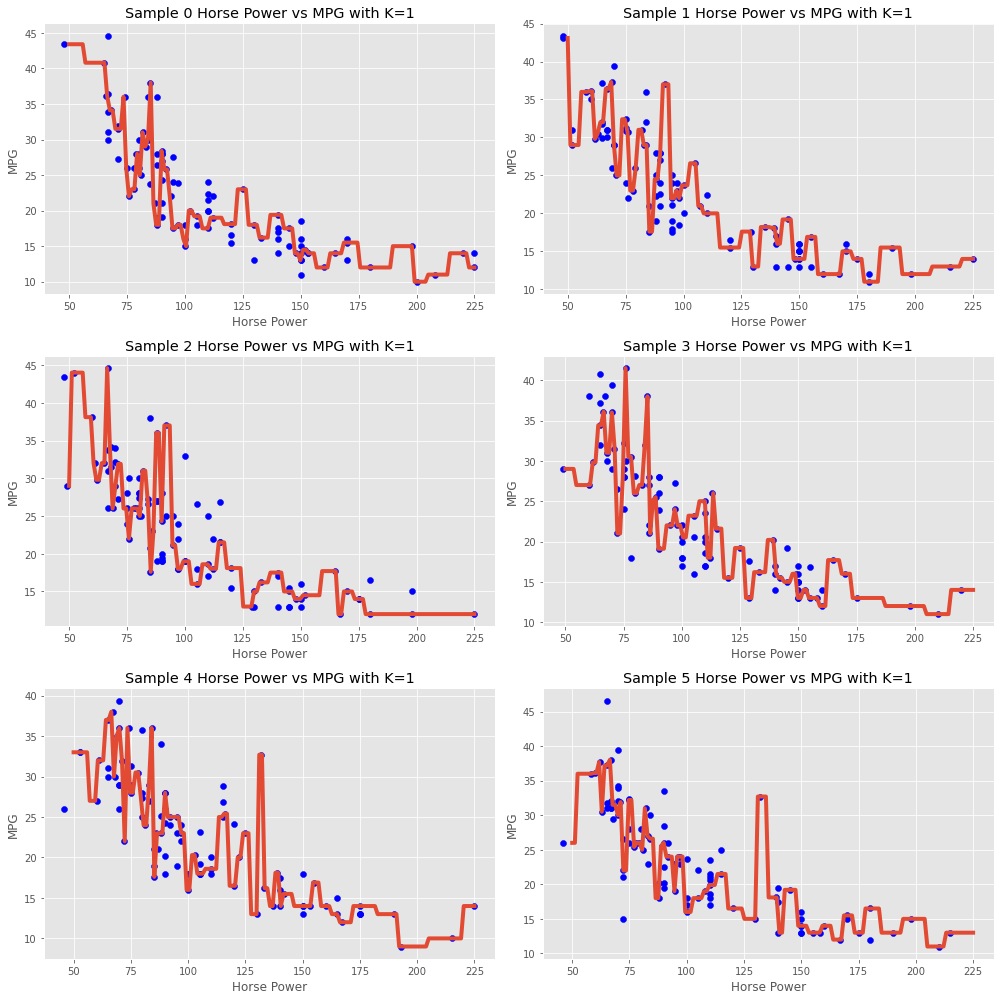

In [20]:
fig, axs = plt.subplots(3,2,figsize=(14, 14))
plt_samples_given_k(axs, cars, 1)

#### Training various samples When K = 5

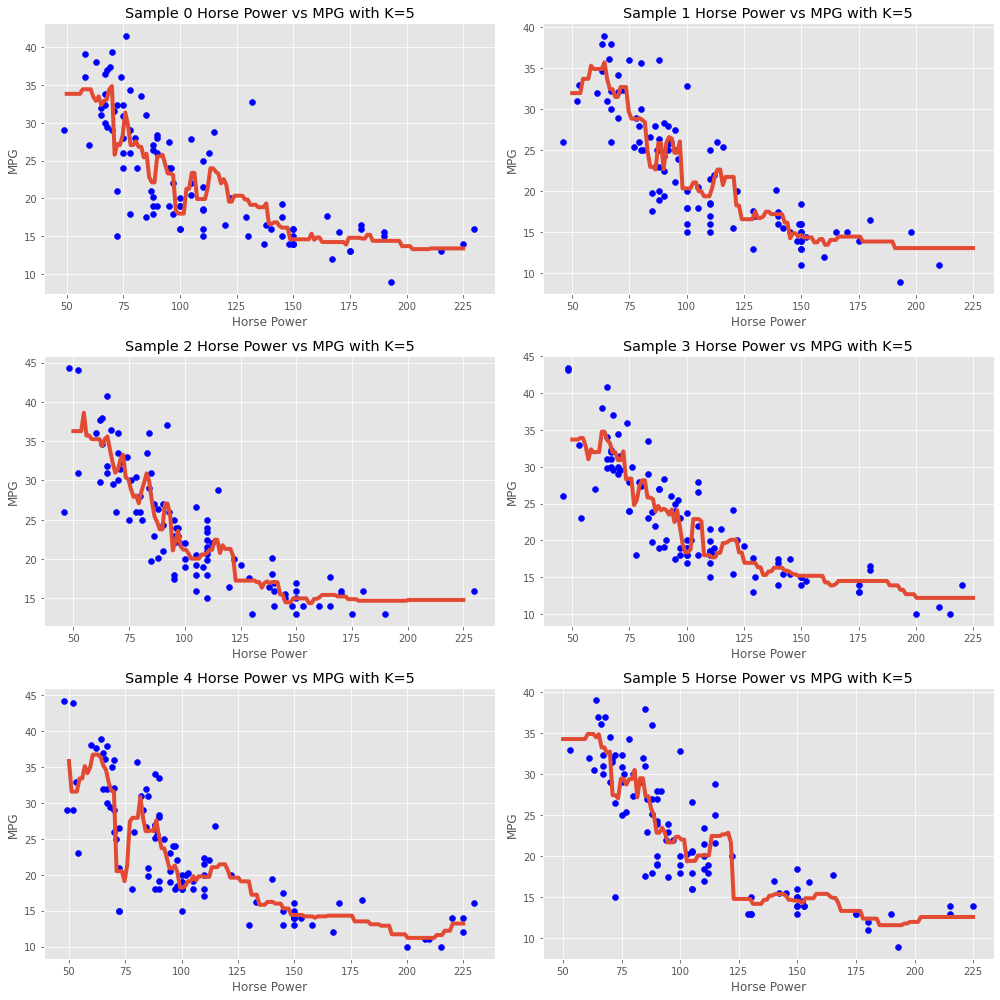

In [21]:
fig, axs = plt.subplots(3,2,figsize=(14, 14))
plt_samples_given_k(axs, cars, 5)

#### Training various samples When K = 10

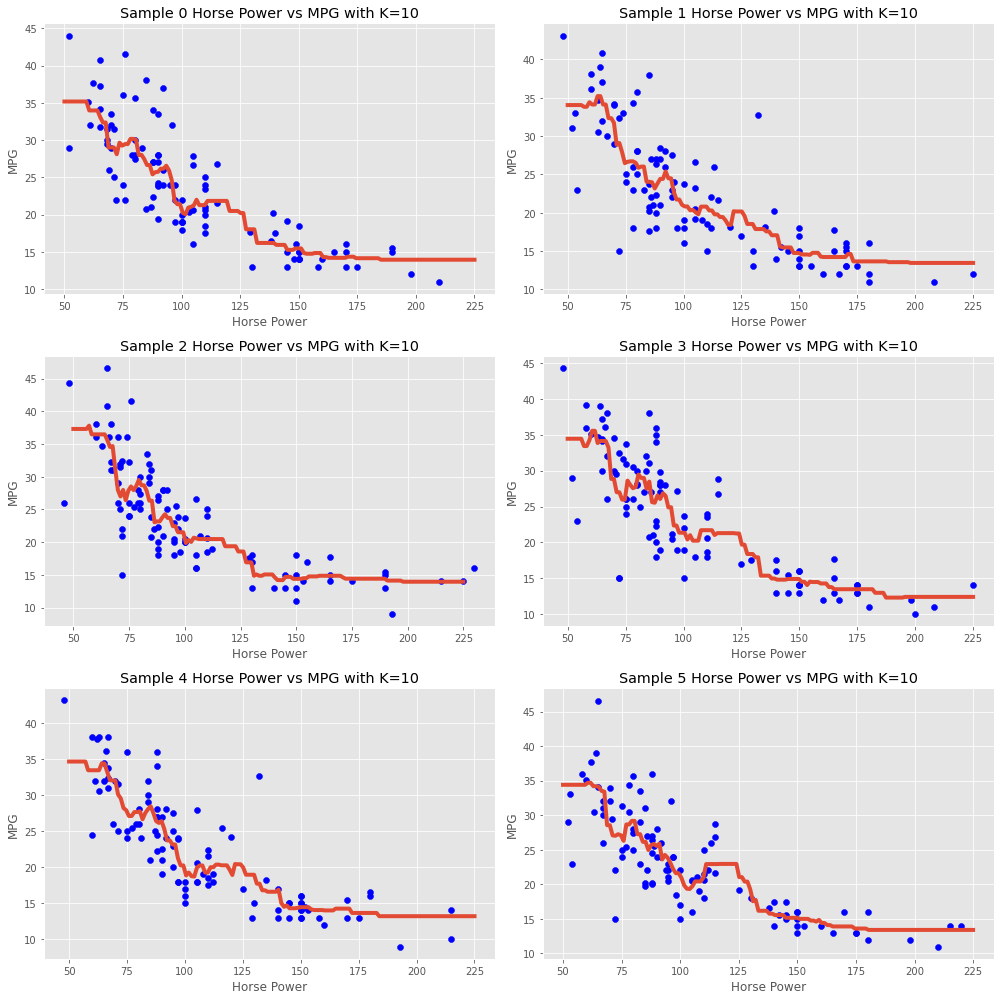

In [22]:
fig, axs = plt.subplots(3,2,figsize=(14, 14))
plt_samples_given_k(axs, cars, 10)

#### Training various samples When K = 80

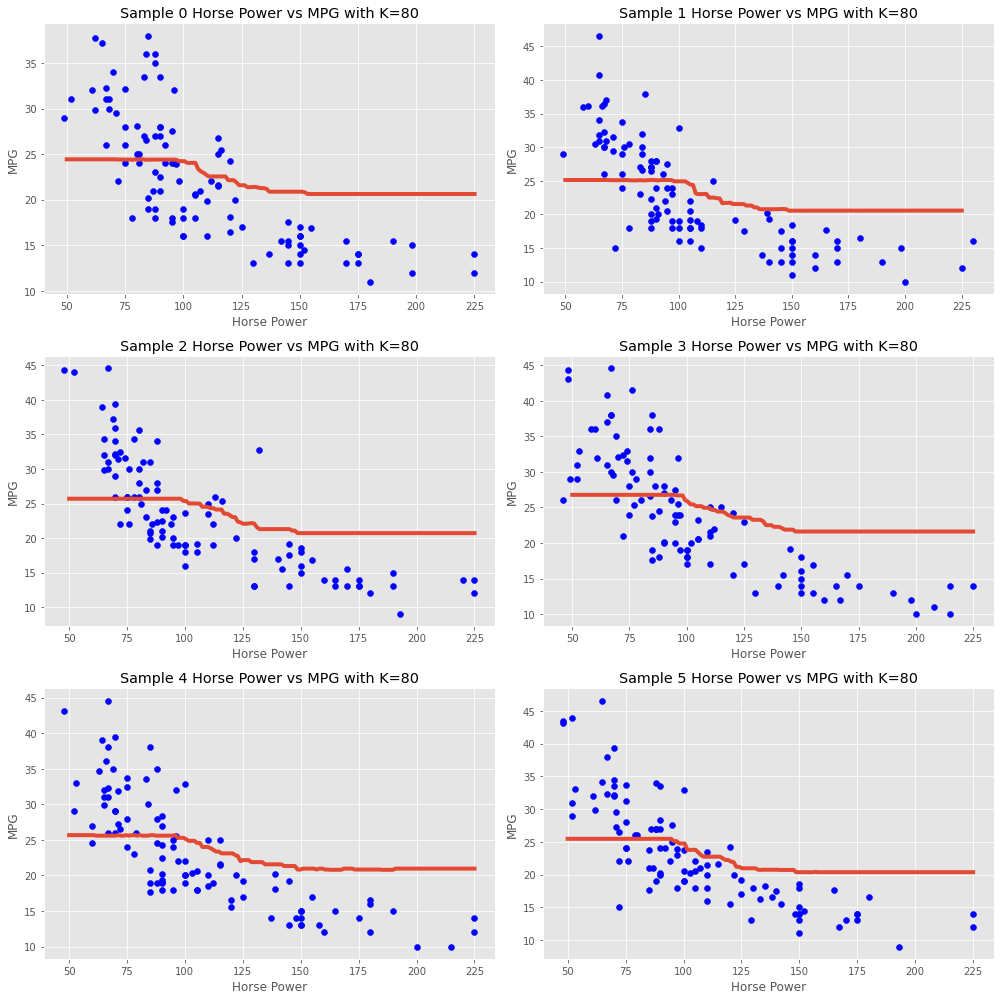

In [23]:
fig, axs = plt.subplots(3,2,figsize=(14, 14))
plt_samples_given_k(axs, cars, 80)

## Questions for each value of k:
* What happens to the predictions as the sample changes?
* How well do you think this model predicts on unknown data?
* Which model is most sensitive to changes in the sample group?
* As k approaches n (the number of observations in the sample), what will the red line look like?

# The Details of Bias and Variance

### Variance: 

A model with **high variance** is **overfit** to the training data and doesn't generalize well to other data. This happens when we have a very complicated model with many independent features, making the model sensitive to small fluctuations in the training set.

*Measurement*: 


the average variance of predicted values from a single model trained on different samples of a training set 
<!-- (from model to model, using different samples, how much do the predicted values vary from eachother?)  -->

Which model demonstrates this? Meaning which k value demonstrates this?


### Bias:
A model with **high bias** is **underfit** and individual predictions deviate greatly from their actual values. Suppose you had a car and wanted to predict its MPG but also you are lazy so you used the mean MPG from the training set.  That's not great. You're not paying good attention to the data in the training sample.

*Measurement*: the average of $|\hat y- y|$ from a single model trained on different samples of a training set

<!-- The distance from the prediction to the actual value averaged over different samples using a single model -->

Note: If we predict well on the training set well we will generally have low bias.

Which model demonstrates this?

### Three sources of error: Bias, variance, and irreducible error

We'll come back to these again and again and again through the course. The mean-squared error of a model can be decomposed into three components. (We will spend more time on  MSE soon) 

<img src="img/bias_var.png">


Note that we don't ever actually know the values of these components, but they are useful in understanding how we make the best possible prediction.

1. The **irreducible error/noise** is the error inherent in any value. Even if we had all possible data (the "population") and could build the best possible model, we can't predict values exactly.
2. The **bias**
3. The **variance**

Again, if we can't know these values, why do we care?

In general, there is a trade-off between bias and variance. A complex model might have very low bias, but will be highly dependent on the sample taken so will have high variance. A simple model might have higher bias, because it underfits, but lower variance, predicting other data nearly as well as the training sample.

Some models have **hyperparameters** that can be tuned. Most represent that trade-off: moving them in one direction will lower the bias and raise the variance; moving them in the other will do the opposite.

Every time you learn about a hyperparameter you should ask yourself if it represents a bias-variance trade-off, and which direction increases bias and decreases variance, and which direction does the opposite.

## Question: 
You want to build a model to predict peoples heights. 

- 1st Model: predicts a person's height based on social security number

- 2nd Model: Predicts a person's height using the mean height of the training sample. 

Which model exhibits high variance and which shows high bias? 


### The Math
$\DeclareMathOperator{\E}{\mathbb{E}}$
$\DeclareMathOperator{\Bias}{Bias}$
$\DeclareMathOperator{\Var}{Var}$

Suppose there is some underlying true function $f(x)$, such that $y = f(x) + \epsilon$, where the noise $\epsilon$ has a mean of zero and standard deviation of $\sigma$. We've created some function $\hat f(x)$ to estimate $y$, and want $|y - \hat f(x)|$ to be as small as possible. We can decompose this into three parts: the  square of the **bias**, the **variance**, and the **irreducible error**.

$$\E\left[(y - \hat f(x))^2\right] = \left(\Bias[\hat f(x)]\right)^2 + \Var[\hat f(x)] + \sigma^2$$





I'm not going to go through the derivation; you can find in elsewhere (e.g. [wikipedia](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation)). Instead I'll cover we'll look at an example.

<img src="img/bias_var.png">

### Bias and variance example

Let's see what that looks like with some fake data. Our true function $f$ will be a cosine curve; we'll add some noise to give values for $y$.

In [46]:
sigma = 1

def f(x):
    return np.cos(x)

def y(x):
    return f(x) + stats.norm(0, sigma).rvs(len(x))

In [47]:
xlim = (0, 10)
n_pts = 100
xpts = np.linspace(*xlim, n_pts)
#Generate y values without noise
ypts = f(xpts)

Text(0.5, 0, 'x')

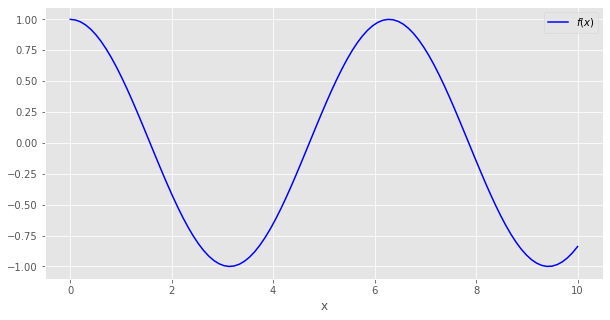

In [56]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xpts, ypts, 'b-', label='$f(x)$')
ax.legend()
ax.set_xlabel('x')

Now we'll choose a training sample and fit a model to those data. We'll use a kNN regressor, since that's a simple model that we've already learned. We'll start with `k=3`.

In [57]:
sample_size = 20
sample = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs(sample_size)
#generate our y data from our uniform distribution of x values
y_sample = y(sample)

#Create and fit our x sample data and our y values 
#y values calculated from the function above including noise
model = KNeighborsRegressor(3)
model.fit(sample[:, None], y_sample)
model.predict(xpts.reshape(-1,1))
model.predict(xpts[:, None])

array([ 1.21742004,  1.21742004,  1.21742004,  1.21742004,  1.21742004,
        1.21742004,  1.21742004,  1.21742004,  0.35262143,  0.35262143,
        0.35262143,  0.55910946,  0.97775369,  0.97775369,  0.97775369,
        0.73573409,  0.59326487,  0.59326487,  0.59326487,  0.20375422,
        0.20375422, -0.15110463, -0.15110463, -0.32532211, -0.32532211,
       -0.32532211, -0.32532211, -1.01188466, -1.01188466, -1.39601837,
       -1.39601837, -1.39601837, -1.84612011, -1.84612011, -1.84612011,
       -1.84612011, -1.84612011, -1.84612011, -1.84612011, -1.84612011,
       -0.91188958, -0.91188958, -0.91188958, -0.91188958, -0.91188958,
       -0.91188958, -0.91188958, -0.91188958, -0.91188958, -0.91188958,
       -0.91188958, -0.91188958, -0.91188958, -0.91188958, -0.36671957,
       -0.36671957,  0.0122071 ,  0.0122071 ,  0.0122071 ,  0.0122071 ,
        0.0122071 ,  0.0122071 ,  0.0122071 ,  0.0122071 ,  0.03302843,
        0.03302843,  0.03302843,  0.03302843,  0.03302843,  0.03

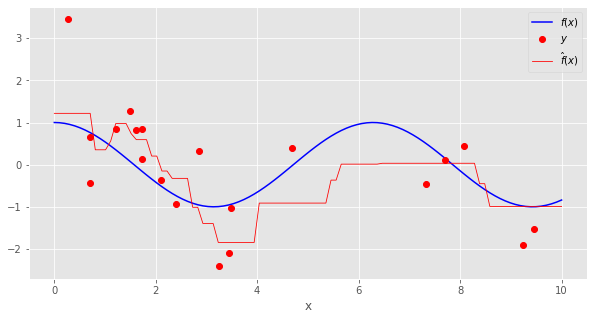

In [58]:
points = ax.plot(sample, y_sample, 'ro', label='$y$')
ax.plot(xpts, model.predict(xpts[:, None]), 'r-', lw=0.8, label='$\hat{f}(x)$')
ax.legend()
fig

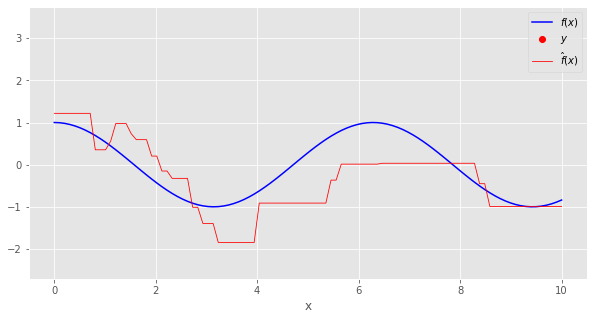

In [59]:
points[0].remove()
fig

But to make sense of bias and variance, we need to consider a large number of training samples, and build a model for each. In reality we only have our one training sample, but we're doing this to try to understand the concept.

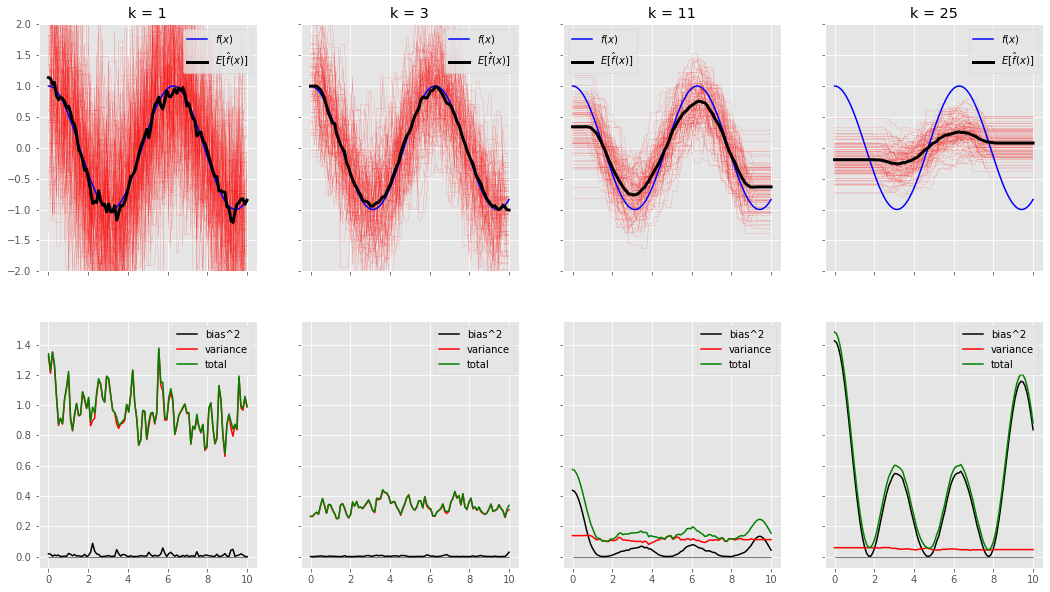

In [61]:
fig, ax = plt.subplots(2, 4, figsize=(18,10), sharey='row', sharex='all')

n_trials = 100
sample_size = 50
for i, k in enumerate((1, 3, 11, 25)):
    predictions = np.zeros((n_trials, n_pts))
    for t in range(n_trials):
        sample = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs(sample_size)
        y_sample = y(sample)
        model = KNeighborsRegressor(k)
        model.fit(sample[:, None], y_sample)
        predictions[t, :] = model.predict(xpts[:, None])
        ax[0, i].plot(xpts, predictions[t,:], 'r-', lw=0.1)
    ax[0, i].plot(xpts, ypts, 'b-', label='$f(x)$')
    ax[0, i].plot(xpts, predictions.mean(axis=0), color='#000000', lw=3, label="$E[\hat f(x)]$")

    ax[0, i].set_ylim((-2, 2))
    ax[0, i].set_title(f"k = {k}")
    ax[0, i].legend()
    #ax[1].plot(xpts, predictions.mean(axis=0) - ypts, 'k', label='bias')
    bias = predictions.mean(axis=0) - ypts
    variance = predictions.var(axis=0)
    ax[1, i].plot(xpts, bias**2, 'k', label='bias^2')
    ax[1, i].plot(xpts, variance, 'r', label='variance')
    ax[1, i].plot(xpts, bias**2 + variance, 'g', label='total')
    ax[1, i].plot(xpts, np.zeros_like(xpts), 'k', lw=0.5)

    ax[1, i].legend()

Okay, so how do we tell which model is the best?

# We're stuck with the bias-variance trade off

We can not directly compute the bias and variance of a real model.  So how is the 'correct' model complexity chosen?   
<br/>
Model complexity can be the order of the fit, the number of features, interaction of the features, number of splits (decision tree), number of neurons/layers of a neural net, number of layers....  
<br/>
We can't do anything to reduce the sampling error from the population, but can we find the model complexity that minimizes the sum of the bias and variance?


#### An oversimplified way to consider it...

<img src="img/bias_variance_meme.jpeg" alt="Drawing" style="width: 320px;"/>


If I can't calculate the total error for a real world model, than how can I determine which model is best? 

### The solution: CROSS VALIDATION!

<img src="img/800px-CRISP-DM_Process_Diagram.png" alt="Drawing" style="width: 400px;"/>

Cross validation really has two separate purposes.

- First, it's used to **evaluate your model**. Part of the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) is evaluation; you (usually) need to know how well your model will predict real-world results. There are many ways to measure that, like mean-square-error or mean-absolute-error for regression models, or log loss or brier score or AUC/ROC or F-score some combination of precision and recall or sensitivity and specificity, based on your specific business case, but the key problem is that you can't measure it on your training data.

- Second, it is used for **model comparison**. Over the coming week we'll learn a bunch of different models, and we need to evaluate which will do best for our data. In addition, many of these models have hyperparameters, and we need cross validation to choose the appropriate values, i.e., tuning the hyperparameters. 


Note: You can measure on your training data in some circumstances, either because your statistical measure allows some estimation of the error, or you have an ensemble model where different submodels see different data (out-of-bag error). But those aren't as general.

## Cross Validation:
 - "Cross-validation: is a **model validation technique** for assessing how the results of a statistical analysis will generalize to an independent data set." -Wikipedia   
    
We use cross-validation when:
 1. Attempting to quantify how well a model (of some given complexity) will predict on unseen data
 2. Tuning hyperparameters of models to get best predictions
 3. Choosing between types of models 

<img src="img/cross_val_illustrated.png" alt="Drawing" style="width: 800px;"/>


## The train-test split


<img src="img/types_cross_val.png" alt="Drawing" style="width: 700px;"/>



The simplest approach we can use is the train-test split. You shouldn't call this cross validation, just say "train-test split" or "hold-out validation."

Let's start with the cars dataset that you may have seen before.    
    
To import train test split: 

`from sklearn.model_selection import train_test_split`

In [62]:
cars = pd.read_csv('data/cars.csv')


In [63]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model         398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


There are a few rows without data for horsepower, which is why it shows up as an object. We're just going to throw those away for now without worrying too much if that's okay.

In [64]:
cars = cars[cars.horsepower != '?']
cars.horsepower = cars.horsepower.astype('float128')
cars.mpg = cars.mpg.astype('float128')

In [65]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   mpg           392 non-null    float128
 1   cylinders     392 non-null    int64   
 2   displacement  392 non-null    float64 
 3   horsepower    392 non-null    float128
 4   weight        392 non-null    float64 
 5   acceleration  392 non-null    float64 
 6   model         392 non-null    int64   
 7   origin        392 non-null    int64   
 8   car_name      392 non-null    object  
dtypes: float128(2), float64(3), int64(3), object(1)
memory usage: 36.8+ KB


Text(0, 0.5, 'mpg')

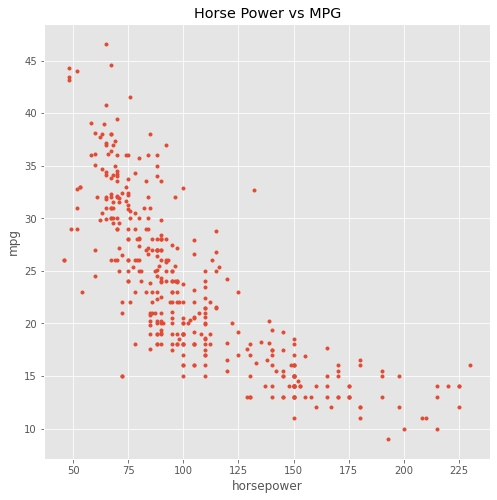

In [66]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cars.horsepower, cars.mpg, '.')
ax.set_title('Horse Power vs MPG')
ax.set_xlabel("horsepower")
ax.set_ylabel("mpg")

### Create my feature matrix and my targets array

In [67]:
X = cars[['horsepower']]
y = cars.mpg

### Split the data

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=31)

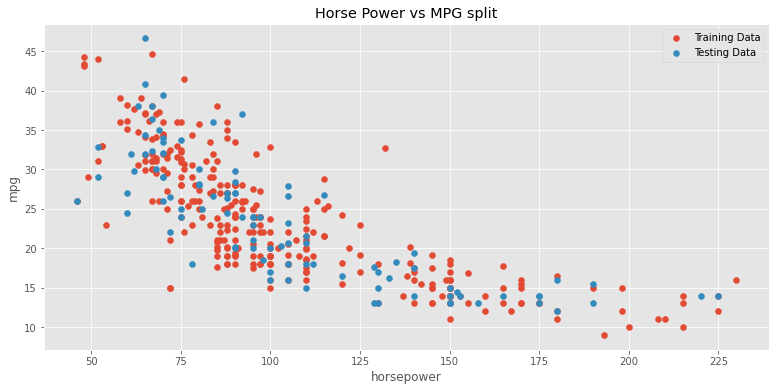

In [69]:
fig, ax = plt.subplots(figsize=(13,6))
ax.scatter(X_train,y_train, label='Training Data')
ax.scatter(X_test,y_test, label='Testing Data')
ax.set_title('Horse Power vs MPG split')
ax.set_xlabel("horsepower")
ax.set_ylabel("mpg")
ax.legend()

### Setting hyperparameters and fitting the model

In [70]:
model = KNeighborsRegressor(20)
model.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=20)

## Model Evaluation:

There is a variety of evaluation metrics and depending on your model, weather or not you are doing regression or classification and other complicating factures due to something like class imballance, you will choose different evaluation metrics. 

Checkout the 3 most common Regression metrics [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)


### One Common Regression Evaluation: MSE

How can we measure the error? A typical choice is to use mean squared error. **The lower the MSE, the better.** 
$$
MSE := \frac{1}{n} \sum_{i=1}^n (\hat{y_i} - y_i)^2
$$

** one reason I love MSE is because the name literally tells you exactly how to calculate it. Take the Mean of the Square of the Error. The error for a given data point is the difference between the observed/actual value and the predicted value.


In [73]:
def MSE(y_hat, y_test):
    '''
    y_hat: predicted y values from x_test 
    y_test: actual y values from x_test
    '''
    return np.sum((y_test - y_hat)**2)/len(y_test)

## Another Common Regression Evaluation: R-Squared

Mean squared error is a good error metric, however the result you are looking for is dependent on the data set. For a more general result there is a scaled version called $R^2$. 
\begin{align}
    R^2 &:= 1 - \frac{SS_{res}}{SS_{tot}} \\
    &= 1 - \frac{\sum_{i=1}^n (\hat{y_i} - y_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
\end{align}    

Where $SS_{res}$ is the sum of the squared residuals and $SS_{tot}$ is the total sum of squares. $R^2$ can be interpreted as the fraction of the variance in the data that is explained by the model.

$R^2$ will be between 0 and 1. 0 means that your model explains none of the variance in the data, while 1 means your model explains all of the variance in the data. **The higher $R^2$, the better!**

In [74]:
#Note that model.score will automatically score the model for you using R^2 (not all models but this is KNN's .score method)

print("R^2 on training data: {}".format(model.score(X_train, y_train)))
print("R^2 on testing data:  {}".format(model.score(X_test, y_test)))
    
    
y_hat = model.predict(X_test)

# Let's also take a look at our MSE for the sake of it
print('MSE on test data: {}'.format(MSE(y_hat, y_test)))

R^2 on training data: 0.7094266740729724
R^2 on testing data:  0.6931721563223361
MSE on test data: 19.11877168367347


Okay, we did a bit better on the training data, as expected...or did we? Let's try a different random split.

In [ ]:
#resplit your data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

#again, train on just the "training" set
model = KNeighborsRegressor(20)
model.fit(X_train, y_train)
print("R^2 on training data: {}".format(model.score(X_train, y_train)))
print("R^2 on testing data:  {}".format(model.score(X_test, y_test)))


y_hat = model.predict(X_test)
# Let's also take a look at our MSE for the sake of it
MSE(y_hat, y_test)

Let's try fitting a lower $k$ but use the same split from the cell above

What should this do?

R^2 on training data: 0.7231314687638914
R^2 on testing data:  0.6699572097630456


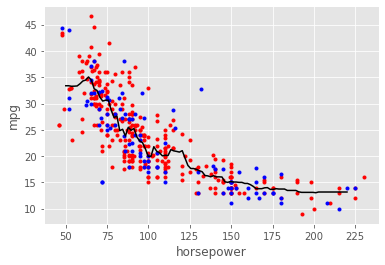

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

fig, ax = plt.subplots()
ax.set_xlabel("horsepower")
ax.set_ylabel("mpg")
ax.plot(X_train, y_train, 'r.')
ax.plot(X_test, y_test, 'b.')


model = KNeighborsRegressor(15)
model.fit(X_train, y_train)
xpts = np.linspace(50, 220, 100).reshape(-1, 1)
ax.plot(xpts, model.predict(xpts), 'k-')

print("R^2 on training data: {}".format(model.score(X_train, y_train)))
print("R^2 on testing data:  {}".format(model.score(X_test, y_test)))

In [76]:
#another MSE function that can take a model as a parameter
def mean_squared_error(model, X, y):
    return np.mean((model.predict(X) - y) **2)

There's a graph you've probably seen showing the error in the training and test sets for different complexities. Let's see if we can reproduce it.

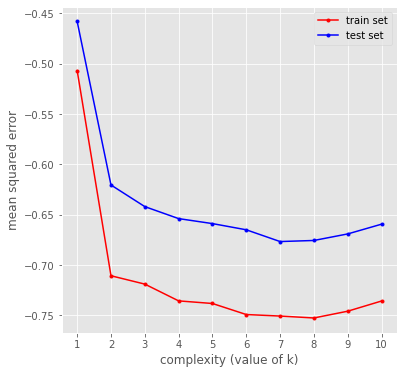

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

train_score = []
test_score = []

for k in range(1, 11):
    model = KNeighborsRegressor(k)
    model.fit(X_train, y_train)
#     train_score.append(mean_squared_error(model, X_train, y_train))
#     test_score.append(mean_squared_error(model, X_test, y_test))
    train_score.append(-model.score(X_train, y_train))
    test_score.append(-model.score(X_test, y_test))

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1, 11), train_score, '.-r', label="train set")
ax.plot(range(1, 11), test_score, '.-b', label="test set")
ax.set_xlabel('complexity (value of k)')
ax.set_ylabel('mean squared error')
ax.legend()
ax.set_xticks(range(1, 11))
plt.show()

That's great! So we do better with the training set than the test set for any complexity. We have a minimum value of around 7-8. Let's try some many more splits.

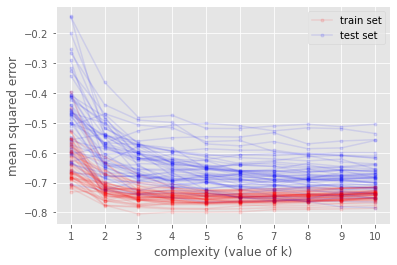

In [102]:
fig, ax = plt.subplots()

for t in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    train_score = []
    test_score = []

    for k in range(1, 11):
        model = KNeighborsRegressor(k)
        model.fit(X_train, y_train)
#         train_score.append(mean_squared_error(model, X_train, y_train))
#         test_score.append(mean_squared_error(model, X_test, y_test))
        train_score.append(-model.score(X_train, y_train))
        test_score.append(-model.score(X_test, y_test))
    if t == 0:
        ax.plot(range(1, 11), train_score, 'r.-', label="train set", alpha=0.1)
        ax.plot(range(1, 11), test_score, 'b.-', label="test set", alpha=0.1)
    else:
        ax.plot(range(1, 11), train_score, 'r.-', alpha=0.1)
        ax.plot(range(1, 11), test_score, 'b.-', alpha=0.1)
        
ax.set_xlabel('complexity (value of k)')
ax.set_ylabel('mean squared error')
# ax.set_ylim(5, 60)
ax.legend()
ax.set_xticks(range(1, 11))
plt.show()

Overall, this isn't all that consistent. We need something better.

## BETTER: Use K-fold Cross Validation

*Do not confuse the new k variable in k-fold cross validation with the k hyperparameter in KNN.

<img src="img/types_cross_val.png" alt="Drawing" style="width: 700px;"/>


With Cross Validation, we randomly partition the data into $k$ groups, $D_1$, $D_2$, ..., $D_k$. For each $i \in [1..k]$ we:

 * Build a model using $D_{j \ne i}$ as a training data
 * Calculate the error of the model on $D_i$
 
We average all these errors to compute the overall error of the model. We can either compare those  across different models to choose the best model or use that number to report the actual error of our one model.

There isn't a clear "best" value for $k$(Number of Folds). The extreme version of k-fold cross validation, when $k=n$, is called leave-one-out cross validation. That's generally not so good, and $k=2$ is not so good, but experience has shown that other choices are fine. I like $k=5$.

So suppose we have fifteen data points (labeled a...o) and we're doing 5-fold cross validation. We'll put the 1st three in the first fold, the next three in the next fold, and so on.

We would build 5 different models (one for each split column, below) using the "train" data points, test each on the "TEST" data points, and average the results.

data point | fold | 1st split  | 2nd split | 3rd split | 4th split | 5th split
---|---|---|---|---|---|---
 a | 1 | **test** | train | train | train | train | 
 b | 1 | **test** | train | train | train | train | 
 c | 1 | **test** | train | train | train | train | 
 d | 2 | train | **test** | train | train | train | 
 e | 2 | train | **test** | train | train | train | 
 f | 2 | train | **test** | train | train | train | 
 g | 3 | train | train | **test** | train | train | 
 h | 3 | train | train | **test** | train | train | 
 i | 3 | train | train | **test** | train | train | 
 j | 4 | train | train | train | **test** | train | 
 k | 4 | train | train | train | **test** | train | 
 l | 4 | train | train | train | **test** | train | 
 m | 5 | train | train | train | train | **test** | 
 n | 5 | train | train | train | train | **test** | 
 o | 5 | train | train | train | train | **test** | 

**Question:** Generally we shuffle the data points first. Why?

We could write code to do this, but `sklearn` has already done that. One confusing thing about the `KFold` object in `sklearn` is that it returns indices, not the data themselves. Here's how we use it.

In [90]:
kf = KFold(n_splits=5, shuffle=True)
for train_indices, test_indices in kf.split(X_train):
    print(len(train_indices), train_indices[:10], len(test_indices), test_indices[:10])
    
X_train.values[:5]

235 [0 1 2 3 4 5 6 7 8 9] 59 [10 12 13 16 33 44 48 52 55 57]
235 [ 0  1  3  4  5  6  7  9 10 11] 59 [ 2  8 15 29 32 36 37 41 50 67]
235 [ 0  1  2  3  4  7  8  9 10 12] 59 [ 5  6 11 19 20 24 25 27 31 49]
235 [ 0  1  2  3  5  6  7  8  9 10] 59 [ 4 22 23 26 28 30 35 38 42 43]
236 [ 2  4  5  6  8 10 11 12 13 15] 58 [ 0  1  3  7  9 14 17 18 21 34]


array([[ 84.],
       [130.],
       [133.],
       [ 92.],
       [ 81.]], dtype=float128)

In [91]:
np.random.seed(42)
#use the sklearn KFold
kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
#Create a score accumulator
fold_scores = []

#Iterate through the 5 splits
for train_indices, test_indices in kf.split(X_train):
    model = KNeighborsRegressor(10)
    model.fit(X_train.values[train_indices], y_train.values[train_indices])
    fold_scores.append(model.score(X_train.values[test_indices], y_train.values[test_indices]))

print(f"R^2 score against each test set: {[round(score, 2) for score in fold_scores]}")
print(np.mean(fold_scores))

R^2 score against each test set: [0.66, 0.69, 0.69, 0.78, 0.62]
0.6862169557768605


So when we get an average score of 0.69, that means our Hyperparameter ${k}$ = 10 should return an average R^2 score of this value. Now we won't have so much variety in our error metric when we compare different Hyperparameters/models. 

Let's do the same error-vs-complexity graph using 5-fold cross validation.

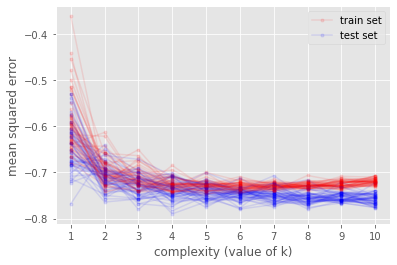

In [104]:
fig, ax = plt.subplots()

for t in range(50):
    #Do KFold 50 times to look at more accurate errors scores when comparing differen n_neighbors(k)
    kf = KFold(n_splits=5, shuffle=True)
    scores = []

    train_score = []
    test_score = []

    for k in range(1, 11):
        train_fold_scores = []
        test_fold_scores = []

        for train_indices, test_indices in kf.split(X):
            model = KNeighborsRegressor(k)
            model.fit(X.values[train_indices], y.values[train_indices])
            train_fold_scores.append(mean_squared_error(model, X.values[train_indices], y.values[train_indices]))
            test_fold_scores.append(mean_squared_error(model, X.values[test_indices], y.values[test_indices]))

#         train_score.append(np.mean(train_fold_scores))
#         test_score.append(np.mean(test_fold_scores))
        train_score.append(-model.score(X_train, y_train))
        test_score.append(-model.score(X_test, y_test))
    if t == 0:
        ax.plot(range(1, 11), train_score, 'r.-', label="train set", alpha=0.1)
        ax.plot(range(1, 11), test_score, 'b.-', label="test set", alpha=0.1)
    else:
        ax.plot(range(1, 11), train_score, 'r.-', alpha=0.1)
        ax.plot(range(1, 11), test_score, 'b.-', alpha=0.1)
        
ax.set_xlabel('complexity (value of k)')
ax.set_ylabel('mean squared error')
# ax.set_ylim(5, 60)
ax.legend()
ax.set_xticks(range(1, 11))
plt.show()

A couple other notes.

Many `sklearn` models include "CV" versions that use cross validation to calculate hyperparameters automatically.

**Stratified cross validation** is a variation in which the partitions are chosen to have similar distributions of labels.

## Overfitting on the testing data

There's a problem with all this. Because the model and hyperparameters are chosen based on the training and testing data, the errors of the model aren't an accurate representation of how it would behave on outside data. If we want to know how it will behave in general, we need to hold out additional data. In this case we have

 * **Training data** are used to fit the model.
 * **Validation data** are used to choose the model and hyperparameters. Once these are determined, these are combined with the training data to re-fit the model.
 * **Hold-out data** are used to evaluate the final accuracy of the model. 
 
<img src="img/cross_val_illustrated.png" alt="Drawing" style="width: 800px;"/>


People use different terms for the splits.

* All data -> Train, Test, Hold-out (This is what I typically say)

* All data -> Train, Validate, Test

* All data -> Train, Validate, Hold-out (in visual above) (maybe most common)

* All the same idea.
 
For each of these we can use either simple hold-out validation or k-fold cross validation.

We do this to:   
 * Compare different models 
     - Example: Compaere KNN to Linear Regression to Logistic Regression...
 * Compare models with different parameters 
     - Example: Different n_neighbors(k) or different distance metrics
 * Compare models with different features 
     - ompare different models

    Example: Compaere KNN to Linear Regression to Logistic Regression...

Compare models with different parameters

    Example: Different n_neighbors(k) or different distance metrics

Compare models with different features

    Example: Maybe take out the engine size or include color and make of car...

Example: Maybe take out the engine size or include color and make of car...

# What to do if your model is overfitting

Pretty common.  If you are starting with 5-10 features that can already be pretty complex.  

1. Get more data...  (not usually possible/practical but almost always the easy answer)
2. Subset Selection: keep only a subset of your predictors (ie, dimensions)
3. Regularization: restrict your models parameter space (Next Week)
4. Dimensionality Reduction: project the data into a lower dimensional space (later in course)

# Subset Selection:

The features you select to put into your model will dictate how well you model preforms.  As this is a important idea, what ways can we try different features?   

   
What if we try every combination of features and find the best score?


### Best subset:
- Try every combination of `p` predictors
 * Computationally intensive.  

## Stepwise:
- Iteratively pick predictors to be in/out of the final model.

## Forward Stepwise Selection   
    
 1. Create a model for every feature on its own.  Choose the feature with the best score.   
 2. Run model with 2 features, best feature and every other feature.  Choose model features that have best score.   
 3. Continue adding features until increase of score becomes not worth extra features or you run out of features.   
 
   
Is this better then just trying all combinations?   
   
Why may this not be good?
 <img src="img/step_forward.png">

## Review Success Criteria

Today I will be successful if I can... 

 * Describe the three kinds of model error
 * Identify what types of models have high bias and high variance
 * Name two different Error Metrics and calculate MSE
 * Explain k-fold cross validation
 * Explain the training, validation, testing data sets

<img src="img/target.png">

# K-Fold in practice

In [ ]:
np.random.seed(42)
from sklearn.model_selection import cross_validate
## Let's build a model, cross-validate it and get the test score

data = cars.copy()

#Using all but one of our features for now... 
y = data.pop('mpg')

X = X.iloc[:, :-1]

#Here X_test/y_test is our holdout set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

# Cross validate against X_train and y_train... this will create 
k_vals = [1, 3, 5, 7, 9, 11, 13, 17, 20, 25, 35, 40, 80]


cv_scores = []
test_scores = []

## building several models with different values of k
for k in k_vals:
    model = KNeighborsRegressor(k)
    #Note in cross_validate, it has specifically KFolds cross validation as an option, there are other ways to CV but this is most popular
    cv = cross_validate(model, X_train, y_train, cv = KFold(n_splits = 5, shuffle=True))['test_score'].mean()

    # store the average score in accumulators to compare later
    cv_scores.append(cv)
    # lets see how we compare against the holdout data
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    test_scores.append(test_score)

In [ ]:
fig, ax = plt.subplots()
ax.plot(k_val, cv_scores, label = 'cross-val scores')
ax.plot(k_val, test_scores, label = 'test scores')
ax.set_xlabel('K Hyperparameter')
ax.set_ylabel('R Squared Score')
ax.legend();